In [14]:
import torch
import random
import numpy as np

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [15]:
# import pandas as pd
# import os
# import json
# from tqdm import tqdm

# # Paths
# input_folder = '../outputs-original-full'
# output_folder = '../outputs'
# os.makedirs(output_folder, exist_ok=True)  # make sure output folder exists

# # Load your sampled test CSV
# df = pd.read_csv('../../dataset/test_data.csv')
# df_sample = df.sample(n=100, random_state=42)
# print(df_sample)
# # Iterate through all JSONL files in the original folder
# for filename in os.listdir(input_folder):
#     if filename.endswith('.jsonl'):
#         input_path = os.path.join(input_folder, filename)
#         output_path = os.path.join(output_folder, filename)
#         filtered_results = pd.DataFrame()
#         df_results = pd.read_json(input_path, lines=True)
#         for index in tqdm.tqdm(range(len(df_sample))):
#             row = df_sample.iloc[index]
#             # Use your correct access method
#             print(df_results["Row Number"])
#             curr_row = df_results[df_results["Row Number"] == int(row["Row Number"])].iloc[0]
#             filtered_results = pd.concat([filtered_results, pd.DataFrame([curr_row])], ignore_index=True)

#         filtered_results.to_json(output_path, orient='records', lines=True)


#         print(f"Saved filtered results for {filename} with original formatting and sample order")



Data Summary:
Model     Condition    Dataset
DAPO-32B  Default CoT  Full       1
                       Sample     1
          Empty CoT    Full       1
                       Sample     1
NRR-1.5B  Default CoT  Full       1
                       Sample     1
          Empty CoT    Full       1
                       Sample     1
OSS-20B   Default CoT  Full       1
                       Sample     1
          Empty CoT    Full       1
                       Sample     1
OpenT-7B  Default CoT  Full       1
                       Sample     1
          Empty CoT    Full       1
                       Sample     1
QwQ-32B   Default CoT  Full       1
                       Sample     1
          Empty CoT    Full       1
                       Sample     1
Name: Score, dtype: int64

Generating academic figure...
Saved: model_performance_comparison.pdf


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved: model_performance_comparison.png
Saved: model_performance_comparison.eps


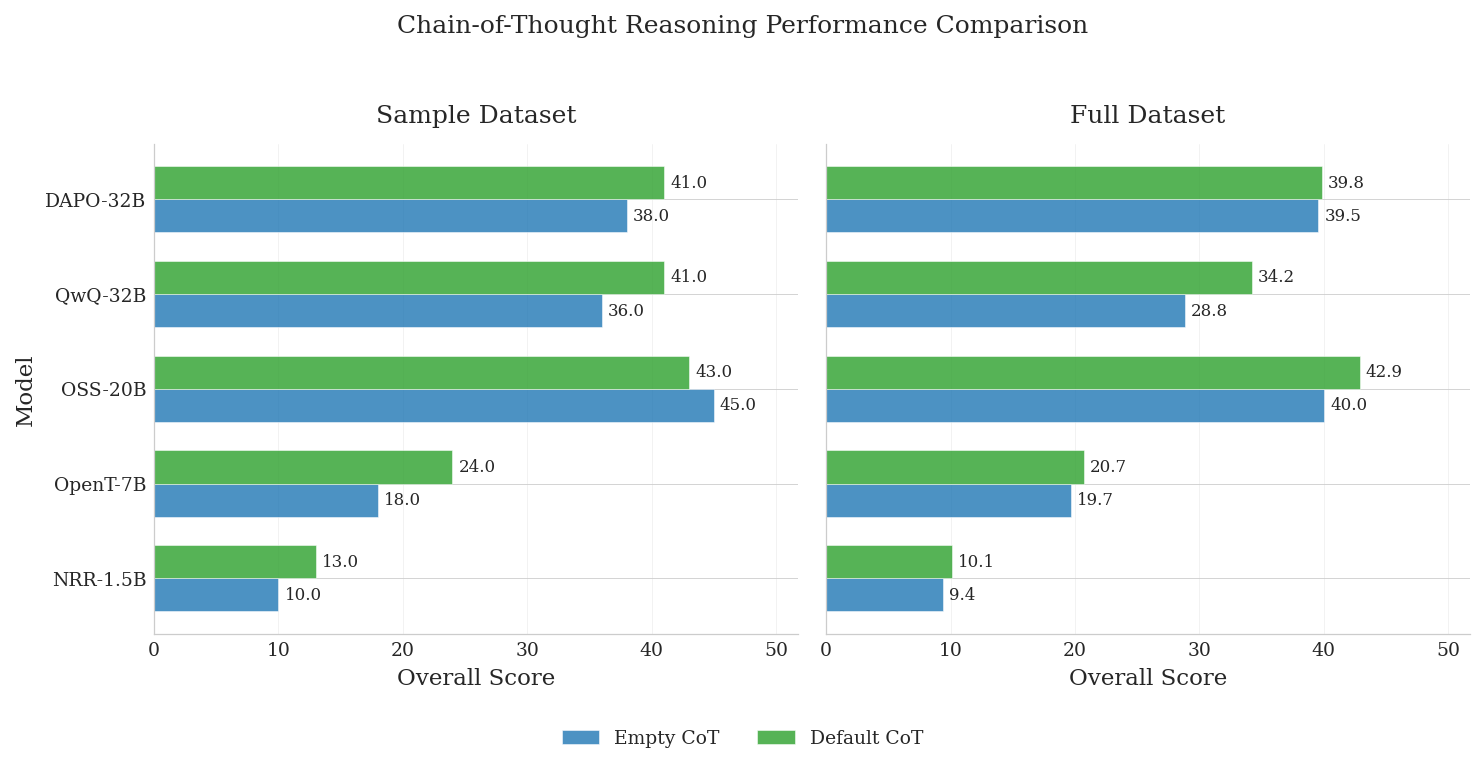

In [18]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Configure matplotlib for LaTeX compatibility and publication quality
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif', 'Times', 'Liberation Serif', 'serif'],
    'text.usetex': False,  # Set to True if LaTeX is installed
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 13,
    'axes.linewidth': 0.6,
    'grid.linewidth': 0.4,
    'lines.linewidth': 1.2,
    'patch.linewidth': 0.5,
    'xtick.major.width': 0.6,
    'ytick.major.width': 0.6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

def get_model_name(filename):
    """Extract and standardize model names for academic presentation."""
    filename_lower = filename.lower()
    
    # Model name mapping for consistent academic presentation
    model_mapping = {
        'dapo': 'DAPO-32B',
        'qwq': 'QwQ-32B', 
        'oss': 'OSS-20B',
        'nemotron': 'NRR-1.5B',
        'openthinker': 'OpenT-7B'
    }
    
    for key, name in model_mapping.items():
        if key in filename_lower:
            return name
    
    # Fallback extraction from filename structure
    parts = filename.replace('.json', '').split('_')
    return parts[1] if len(parts) > 1 else filename

def collect_evaluation_data():
    """Collect and process evaluation results from both dataset sizes."""
    data_records = []
    
    dataset_sources = {
        "../results": "Sample",
        "../results-original-full": "Full"
    }
    
    for directory, dataset_size in dataset_sources.items():
        if not os.path.exists(directory):
            print(f"Directory not found: {directory}")
            continue
            
        for filename in os.listdir(directory):
            if not filename.endswith(".json"):
                continue
                
            filepath = os.path.join(directory, filename)
            
            try:
                with open(filepath, "r", encoding='utf-8') as file:
                    results = json.load(file)
                    
                overall_score = results.get("overall", {}).get("average")
                if overall_score is None:
                    continue
                
                # Classify reasoning condition
                if "zero_shot_empty" in filename:
                    reasoning_condition = "Empty CoT"
                elif "zero_shot_original" in filename:
                    reasoning_condition = "Default CoT"
                    
                    # Filter OSS model variants (keep only 'low' complexity)
                    if "oss" in filename.lower() and "low" not in filename.lower():
                        continue
                else:
                    continue
                
                model_name = get_model_name(filename)
                
                data_records.append({
                    "Model": model_name,
                    "Condition": reasoning_condition,
                    "Dataset": dataset_size,
                    "Score": overall_score
                })
                
            except (json.JSONDecodeError, KeyError, IOError) as error:
                print(f"Error processing {filename}: {error}")
    
    return pd.DataFrame(data_records)

def create_academic_figure(df):
    """Generate publication-quality comparison figure."""
    
    if df.empty:
        raise ValueError("No data available for plotting")
    
    # Academic color scheme - colorblind friendly
    condition_colors = {
        "Empty CoT": "#1f77b4",    # Professional blue
        "Default CoT": "#2ca02c"   # Professional green
    }
    
    # Model ordering by parameter count
    model_hierarchy = ["NRR-1.5B", "OpenT-7B", "OSS-20B", "QwQ-32B", "DAPO-32B"]
    available_models = [m for m in model_hierarchy if m in df["Model"].values]
    
    # Create figure with academic proportions (suitable for two-column papers)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    fig.subplots_adjust(wspace=0.05)
    
    datasets = ["Sample", "Full"]
    bar_width = 0.35
    
    for idx, (ax, dataset) in enumerate(zip(axes, datasets)):
        dataset_data = df[df["Dataset"] == dataset]
        
        if dataset_data.empty:
            ax.text(0.5, 0.5, f'No {dataset} data', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=10, style='italic')
            ax.set_title(f'{dataset} Dataset', fontweight='medium', pad=10)
            continue
        
        # Position models on y-axis
        y_positions = np.arange(len(available_models))
        
        # Plot bars for each reasoning condition
        for condition_idx, condition in enumerate(["Empty CoT", "Default CoT"]):
            condition_data = dataset_data[dataset_data["Condition"] == condition]
            
            # Extract scores for each model
            scores = []
            for model in available_models:
                model_data = condition_data[condition_data["Model"] == model]
                score = model_data["Score"].iloc[0] if not model_data.empty else np.nan
                scores.append(score)
            
            # Create horizontal bars
            bars = ax.barh(
                y_positions + condition_idx * bar_width - bar_width/2,
                scores,
                bar_width,
                label=condition,
                color=condition_colors[condition],
                alpha=0.8,
                edgecolor='white',
                linewidth=0.3
            )
            
            # Add score labels
            for bar, score in zip(bars, scores):
                if not np.isnan(score) and score > 0:
                    ax.text(
                        bar.get_width() + 0.5,
                        bar.get_y() + bar.get_height()/2,
                        f'{score:.1f}',
                        ha='left',
                        va='center',
                        fontsize=8,
                        fontweight='medium'
                    )
        
        # Configure axes
        ax.set_yticks(y_positions)
        ax.set_yticklabels(available_models)
        ax.set_xlabel('Overall Score', fontweight='medium')
        
        if idx == 0:
            ax.set_ylabel('Model', fontweight='medium')
        
        ax.set_title(f'{dataset} Dataset', fontweight='medium', pad=10)
        
        # Grid and styling
        ax.grid(True, axis='x', alpha=0.3, linestyle='-', linewidth=0.4)
        ax.set_axisbelow(True)
        
        # Set consistent x-axis range
        max_score = df["Score"].max()
        ax.set_xlim(0, max_score * 1.15)
        
        # Remove spines for cleaner appearance
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Add figure title
    fig.suptitle('Chain-of-Thought Reasoning Performance Comparison', 
                fontsize=12, fontweight='medium', y=0.98)
    
    # Create legend
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=2,
        frameon=False,
        fontsize=9
    )
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig

def main():
    """Main execution function."""
    # Collect data
    print("Collecting evaluation data...")
    df = collect_evaluation_data()
    
    if df.empty:
        print("No data found. Check file patterns and directory paths.")
        return
    
    # Display data summary
    print("\nData Summary:")
    summary = df.groupby(['Model', 'Condition', 'Dataset'])['Score'].count()
    print(summary)
    
    # Generate figure
    print("\nGenerating academic figure...")
    fig = create_academic_figure(df)
    
    # Save high-quality outputs for LaTeX
    output_formats = {
        'model_performance_comparison.pdf': {'format': 'pdf', 'dpi': 300},
        'model_performance_comparison.png': {'format': 'png', 'dpi': 300},
        'model_performance_comparison.eps': {'format': 'eps', 'dpi': 300}
    }
    
    for filename, params in output_formats.items():
        fig.savefig(
            filename,
            format=params['format'],
            dpi=params['dpi'],
            bbox_inches='tight',
            pad_inches=0.1,
            facecolor='white',
            edgecolor='none'
        )
        print(f"Saved: {filename}")
    
    plt.show()

if __name__ == "__main__":
    main()